<a href="https://colab.research.google.com/github/KevinLL218/Mydatabase/blob/master/Detectrom2%20Based%20SegmentationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 828kB/s 
     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=249695e9a1257a8c13d4072a2eac022463c30a5804c3d88885ad303483f69191
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
!cp "drive/MyDrive/light.zip" "dataset1.zip" #dataset
!unzip dataset1.zip     #unzip
!rm -rf "data_rovsc_2/SegmentationClass"  #remove unused folder
!cp "drive/MyDrive/a.json" "ann.json" #annonations

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "./data_rovsc_2/ann.json", "data_rovsc_2/JPEGImages")
register_coco_instances("my_dataset_val", {}, "./data_rovsc_2/val/val.json", "data_rovsc_2/val")


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = "cpu"
cfg.DATALOADER.NUM_WORKERS = 0 ##????? 2??
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/03 15:02:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[06/03 15:02:32 d2.engine.train_loop]: Starting training from iteration 0
[06/03 15:14:50 d2.utils.events]:  eta: 2:59:48  iter: 19  total_loss: 7.098  loss_cls: 1.319  loss_box_reg: 0.0006795  loss_mask: 0.6942  loss_rpn_cls: 3.442  loss_rpn_loc: 1.169  time: 36.9438  data_time: 0.1935  lr: 4.9953e-06  
[06/03 15:19:55 d2.engine.hooks]: Overall training speed: 25 iterations in 0:16:09 (38.7772 s / it)
[06/03 15:19:55 d2.engine.hooks]: Total training time: 0:16:09 (0:00:00 on hooks)
[06/03 15:19:55 d2.utils.events]:  eta: 2:54:34  iter: 27  total_loss: 6.331  loss_cls: 1.284  loss_box_reg: 0.0007396  loss_mask: 0.6936  loss_rpn_cls: 3.377  loss_rpn_loc: 0.9423  time: 37.2419  data_time: 0.1894  lr: 6.7435e-06  


KeyboardInterrupt: ignored

In [ ]:
import logging
import os
from collections import OrderedDict
import torch

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)
from detectron2.modeling import GeneralizedRCNNWithTTA

# 注册数据集

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets.coco import load_coco_json
import pycocotools

In [ ]:
!cp "./data_rovsc_2/JPEGImages/00002500.jpg" "test.jpg"

In [ ]:
!cp "./data_rovsc_2/ann.json" "val.json"

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data.catalog import MetadataCatalog, DatasetCatalog
import fruitsnuts_data
import cv2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
import os
setup_logger()



if __name__ == "__main__":
    cfg = get_cfg()
    cfg.merge_from_file(
        "../../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )
    cfg.DATASETS.TRAIN = ("fruits_nuts",)
    cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
    cfg.DATALOADER.NUM_WORKERS = 2
    # cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
    cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.0025
    cfg.SOLVER.MAX_ITER = (2500)  # 300 iterations seems good enough, but you can certainly train longer
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)  # faster, and good enough for this toy dataset
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

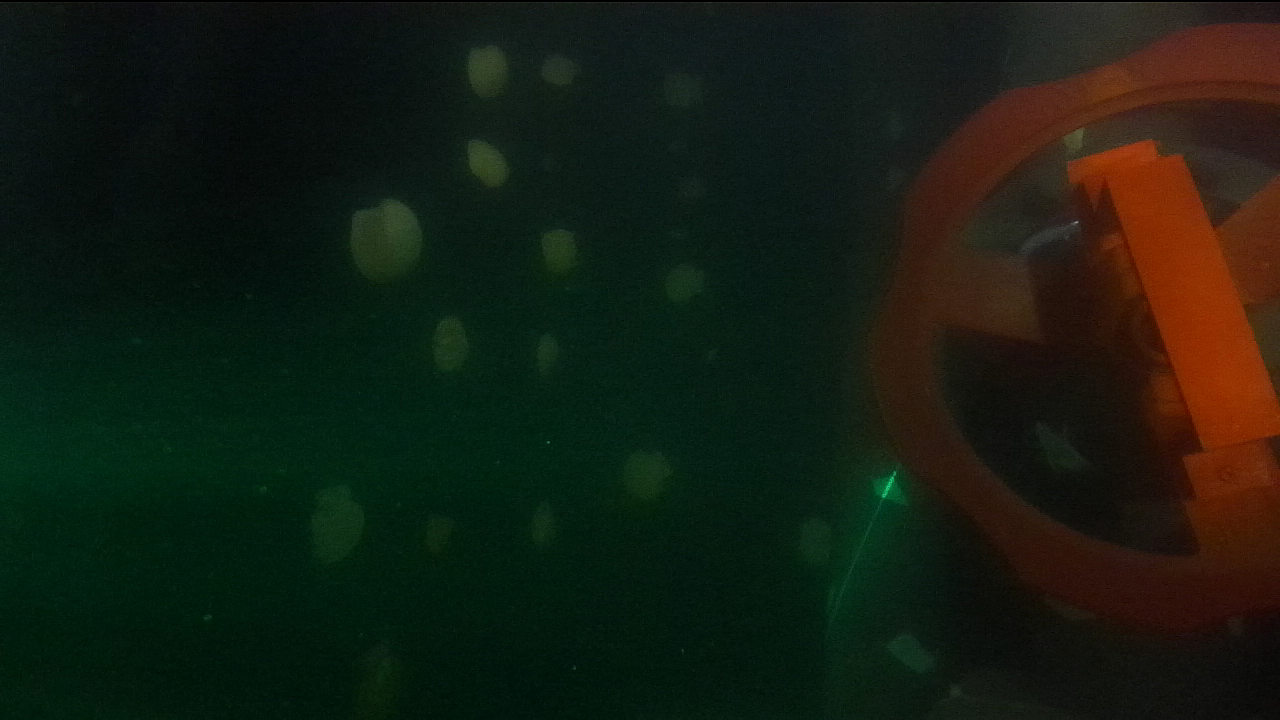

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
#im = cv2.resize(im,(600,400))
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
help(detectron2)

Help on package detectron2:

NAME
    detectron2 - # Copyright (c) Facebook, Inc. and its affiliates.

PACKAGE CONTENTS
    _C
    checkpoint (package)
    config (package)
    data (package)
    engine (package)
    evaluation (package)
    export (package)
    layers (package)
    model_zoo (package)
    modeling (package)
    projects (package)
    solver (package)
    structures (package)
    utils (package)

VERSION
    0.4

FILE
    /usr/local/lib/python3.7/dist-packages/detectron2/__init__.py




In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0], device='cuda:0')
Boxes(tensor([[444.3431,  94.6552, 488.2746, 243.6364],
        [272.1059,  88.0175, 317.7428, 280.7320],
        [113.5408,  71.3891, 158.7340, 290.3122]], device='cuda:0'))


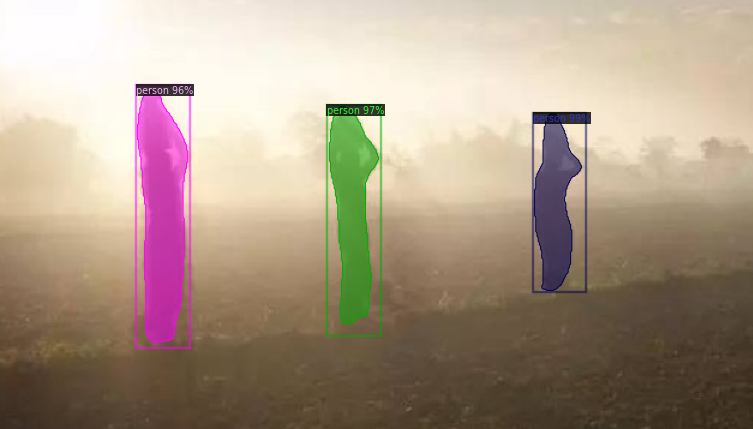

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])